In [1]:


#filepath_calib="C:/Users/tomfa/Desktop/DSP_spectrum_calibration-master/DSP_spectrum_calibration-master/"
filepath_calib="" # using github clone

#Command Path
filepath_stardata="star_data_raw"

#See TFdf dataframe below for relationship of TF catalog to other catalogs
TFnum='04'
#Exact File Name
filename="Capture_054.fit"

#Put files in directory "starname" in directory filepath_stardata or change the following file path to open
file_to_open=filepath_stardata+"/TF"+TFnum+"/"+filename 

output_folder="star_data_spectral"

### User choice!
#optional offset to move violet background near delta redward
#greater than 60 will overlap, which is bad.
#zero for consistency of delta with alpha, beta, gamma, positive to avoiding sampling missing data
ihv_offset=30


SIMPLE  =                    T                                                  
BITPIX  =                   16                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2749                                                  
NAXIS2  =                  700                                                  
BZERO   =           32768.000000                                                
BSCALE  =             1.000000                                                  
DATAMIN =             0.000000                                                  
DATAMAX =           65535.000000                                                
INSTRUME=           'ATIK-460ex: fw rev 3.34'                                   
EXPTIME =           120.000                                                     
DATE-OBS=           '2019-11-13T03:25:48'                                       
XPIXSZ  =           4.540   

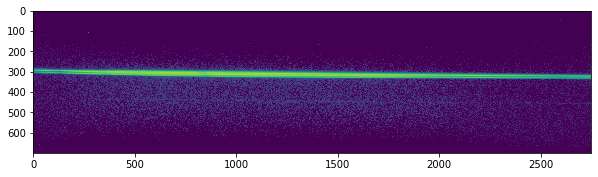

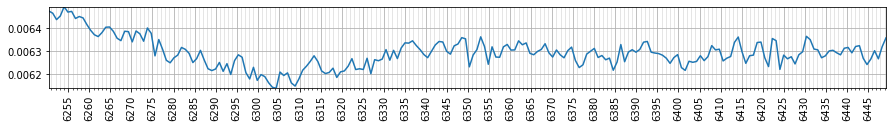

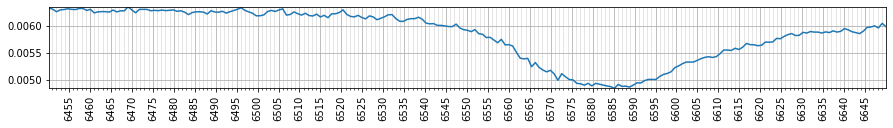

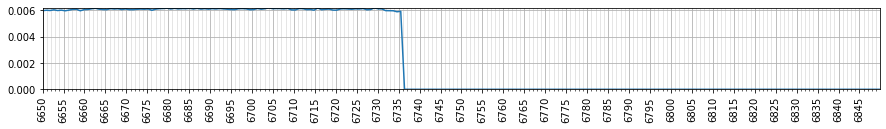

In [36]:
### import packages
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output,display,Math,Latex
import pandas as pd
from astropy.io import fits
from scipy import signal

### load argon calibration quartic coefficient matrices



k0=np.load(filepath_calib+"k0.npy")
k1=np.load(filepath_calib+"k1.npy")
k2=np.load(filepath_calib+"k2.npy")
k3=np.load(filepath_calib+"k3.npy")
k4=np.load(filepath_calib+"k4.npy")






TFdict=[{'num':1,'TF':'01','name':'gam Cas','HD':5394,'mag':2.39},
       {'num':2,'TF':'02','name':'BK Cam','HD':20336,'mag':4.85},
       {'num':3,'TF':'03','name':'6 Cep','HD':203467,'mag':5.18},
       {'num':4,'TF':'04','name':'HD 112028','HD':112028,'mag':5.35},
       {'num':5,'TF':'05','name':'HD 208682','HD':208682,'mag':5.86},
       {'num':6,'TF':'06','name':'HD 9612','HD':9612,'mag':6.57},
       {'num':7,'TF':'07','name':'FF Cam','HD':60062,'mag':7.90},
       {'num':8,'TF':'08','name':'HD 20566','HD':20566,'mag':7.94},
       {'num':9,'TF':'09','name':'HD 203024','HD':203024,'mag':8.86},
       {'num':10,'TF':'10','name':'EM* MWC 680','mag':9.41},
       {'num':11,'TF':'11','name':'EM* StHA 198','mag':10.54},
       {'num':12,'TF':'12','name':'EM* AS 518','mag':10.61},
       {'num':13,'TF':'13','name':'EM* GGR 192','mag':10.67}]

TFdf = pd.DataFrame(TFdict)

#Star Name
starname=TFdf.set_index('TF').loc[TFnum]['name']


#TFdf.loc['04']
#TFdf


###Input Command Path to Raw Star Data:




### load raw data

hdulist = fits.open(file_to_open)  
print(repr(hdulist[0].header))
scidata=hdulist[0].data


###Make sure raw spectrum looks good:




dt=hdulist[0].header['DATE-OBS']
year=dt[0:4]
month=dt[5:7]
day=dt[8:10]
date=year+month+day
#print(date)
hr=dt[11:13]
minute=dt[14:16]
second=dt[17:19]
clockreading=hr+minute+second
#print(clockreading)

outfilename=output_folder+"/TF"+TFnum+"_"+date+"_"+clockreading
print("output to ",outfilename)

###Correct for exposure time
img=scidata/hdulist[0].header['EXPTIME']  #extract data per unit time
y0=hdulist[0].header['YORGSUBF']   #extract starting y line index from header

###Remove Bad Pixels###
import scipy.signal
img_sm = scipy.signal.medfilt(img, [1,3])
bad = (np.abs(img - img_sm) / 100) > .05
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
ymin=0
ymax=800
ind2=np.argmax(img_cr[ymin:ymax,:],0)+ymin
print("Bad Pixels =", sum(sum(bad)))

###Find indc "line" of Spectrum###
pix=np.arange(0,hdulist[0].header['NAXIS1'],1)
lines=np.arange(0,hdulist[0].header['NAXIS2'],1)
m=.0108 
i2500=np.mean(ind2[2400:2600])
print("i2500 =", i2500)
print("y0 =",y0)
b=i2500-m*2500
indc=m*pix+b

###Weighted Average of Nearby Lines###
y=lines
indca, ya = np.meshgrid(indc, lines,indexing='xy')
#print(indca.shape)
sigma=5
w=1/(np.sqrt(2*np.pi)*sigma)*np.e**(-(ya-indca)**2/(2*sigma**2))

###Generate Spectrum by weighted average###
sd= np.sum(w*img_cr,0)

print("indc =",indc)

### find average signal in non-spectrum part of slit
### compute background average and subtract off of spectrum
if i2500>400:
    ybgs=200
else:
    ybgs=550

###Generate spectrum in background area (around 550 or 200)
#bg is not as smart as bg2
#bg=np.mean(img_cr[ybgs-50:ybgs+50,:],0)
b2=ybgs-m*2500
indc2=m*pix+b2
indca2, ya2 = np.meshgrid(indc2, lines,indexing='xy')
sigma2=40
w2=1/(np.sqrt(2*np.pi)*sigma2)*np.e**(-(ya2-indca2)**2/(2*sigma2**2))
bg2= np.sum(w2*img_cr,0)
sdbgs=sd-bg2

#Show background subtracted field
imgbgs=img-1.0*bg2
#plt.plot(imgbgs)
imgbgs[imgbgs<0]=0

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log((imgbgs+.5)**0.1))
plt.show()

###Start wavelength calibration assuming xs is zero
alphaPixel=2557
# find index used for this camera line (i2500woffset) in k matrix
i2500woffset=i2500+y0
lineindex=int(np.round(i2500woffset/10))

### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database
wlfeature=6563
#this is wl of Halpha
pixpk=alphaPixel
#pixel (2557) where Halpha is if xse = 0

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)

# linear interpolation
from scipy.interpolate import interp1d
f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")
#print(f(xse))
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)
f2=interp1d(wle,pix)

###Load transfer function
transfuncM=np.load(filepath_calib+"transfuncM.npy")

# linear interpolation into wavelengths used in MILES database
wlMILES=3500+0.9*np.arange(4367)

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

###siM is now normalized, transferred, but not wavelength(xs) calibrated 
siM=spM/transfuncM

fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6250
xmax=6450
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
ax1.plot(wlMILES[mask],siM[mask])
ax1.set_xticks(major_ticks)
ax1.set_xticks(minor_ticks, minor=True)
ax1.grid(which='both')
ax1.grid(which='minor', alpha=0.4)
ax1.grid(which='major', alpha=1)
ax1.tick_params(axis='x',labelrotation=90)
ax1.autoscale(axis='both',tight=True)

fig, ax2 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6450
xmax=6650
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
ax2.plot(wlMILES[mask],siM[mask])
ax2.set_xticks(major_ticks)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(which='both')
ax2.grid(which='minor', alpha=0.4)
ax2.grid(which='major', alpha=1)
ax2.tick_params(axis='x',labelrotation=90)
ax2.autoscale(axis='both',tight=True)

fig, ax3 = plt.subplots(nrows=1, ncols=1,figsize=(15, 1.5))
xmin=6650
xmax=6850
major_ticks = np.arange(xmin,xmax, 5)
minor_ticks = np.arange(xmin,xmax, 1)
mask = (wlMILES >= xmin) & (wlMILES <= xmax)
ax3.plot(wlMILES[mask],siM[mask])
ax3.set_xticks(major_ticks)
ax3.set_xticks(minor_ticks, minor=True)
ax3.grid(which='both')
ax3.grid(which='minor', alpha=0.4)
ax3.grid(which='major', alpha=1)
ax3.tick_params(axis='x',labelrotation=90)
ax3.autoscale(axis='both',tight=True)

# Determine the centroid of the hydrogen alpha feature and input into next cell

In [37]:
alphacenter=6584

pixel of H-alpha = 2580


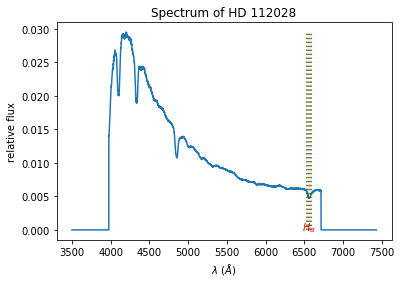

In [38]:
f2=interp1d(wle,pix)
alphaPixel=int(np.round(f2(alphacenter))) 
print(r"pixel of H-alpha =",alphaPixel)



wlfeature=6563
#this is wl of Halpha
pixpk=alphaPixel
#pixel where min or max is found in feature
# find index used for this camera line (i2500woffset) in k matrix
#i2500woffset=i2500+y0
#lineindex=int(np.round(i2500woffset/10))

### To use this, you need to extract values of:
### li2500: the line of spectrum,
### pixfeature: the pixel of the feature
### and wlfeature: the wavelength of the feature 
### From data
### index 0 changes depending on the y range that we used in capture
#li2500=lineindex-26  #260 is index 0, they are spaced by 10 ypixels
#60 is index 0 if we use only the size of the slit I think. Use 6 as subtracted #
#wlfeature=5183.6  pixpk=1109 #Mg from NIST database

#first fit (cubicly) xs vs wl at this i2500 and xs
wl=np.polyval((k4[li2500],k3[li2500],k2[li2500],k1[li2500],k0[li2500]),pixpk)
xs=np.arange(-6,7,2)
lfit=np.polyfit(wl,xs,3)

#extract value of xs corresponding to actual wavelength that index found represents
xse=np.polyval(lfit,wlfeature)

# linear interpolation
from scipy.interpolate import interp1d
f=interp1d(xs,(k4[li2500,:],k3[li2500,:],k2[li2500,:],k1[li2500,:],k0[li2500,:]),fill_value="extrapolate")
#print(f(xse))
#linearly interpolated coefficients of quartic wl vs pixel fit

#wle should hold the calibrated wavelengths inferred from the interpolated coefficients 
#that match the value of xs inferred from matching pixpk and wlfeature 
pix=np.arange(0,2749)
wle=np.polyval(f(xse),pix)
f2=interp1d(wle,pix)

###Load transfer function
transfuncM=np.load(filepath_calib+"transfuncM.npy")

# linear interpolation into wavelengths used in MILES database
wlMILES=3500+0.9*np.arange(4367)

#extend data with zeros above and below
wlmin=wle[0];
wlmax=wle[-1];
wlE=np.insert(wle,0,wlmin);
wlE=np.insert(wlE,0,0);
wlE=np.append(wlE,wlmax);
wlE=np.append(wlE,1000000);

y = np.insert(sdbgs,0,0);
y = np.insert(y,0,0);
y = np.append(y,0);
y = np.append(y,0);

f = interp1d(wlE, y)
spM=f(wlMILES)

###This is final spectrum
siM=spM/transfuncM
maxy=max(siM)
plt.plot(wlMILES,siM)
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");


In [39]:
make sure to save it

SyntaxError: invalid syntax (<ipython-input-39-a8a742205a87>, line 1)

Hydrogen lines: 6563.6 4861.7 4340.6 4102.1
MILES indices of hydrogen lines: (3404, 1513, 934, 669)


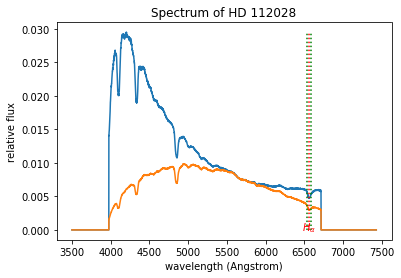

6563.6
0.8349625264775059


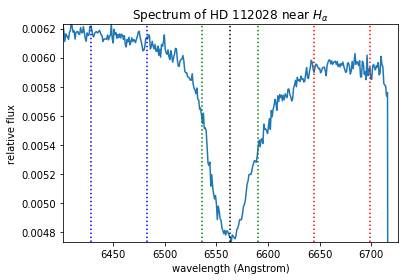

0.833727584672673
0.9500849590640544
0.8047651987111182


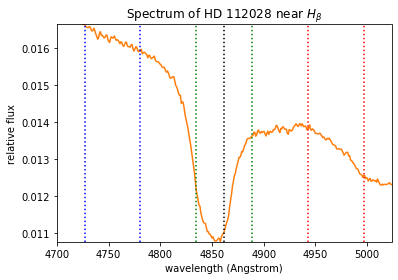

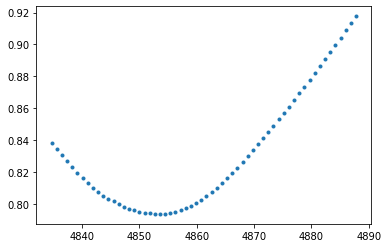

0.793616786197991
0.9177425812543512


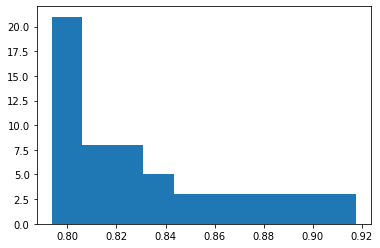

0.8122174784700203


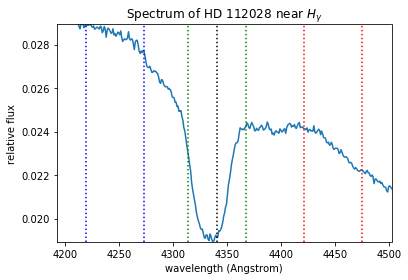

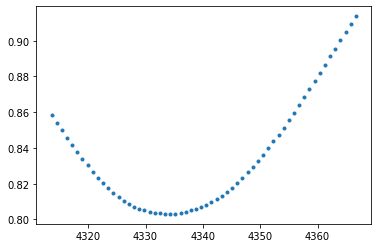

0.8030989446423088
0.913719619661718
0.8678603402596649


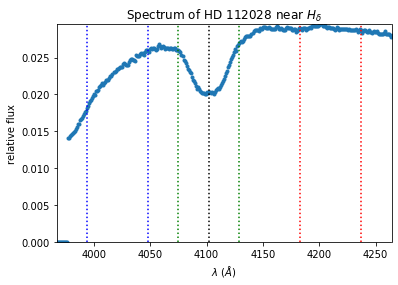

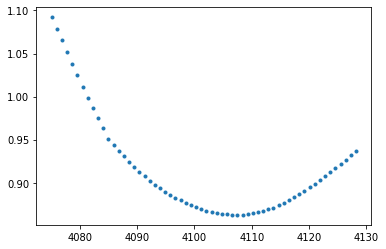

0.8627660722831267
1.092100988899568
normalized signal = 0.8349625264775059 0.8047651987111182 0.8122174784700203 0.8678603402596649


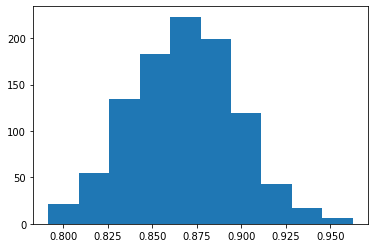

uncertainty =  0.029507584498742762


0.029507584498742762

In [40]:
### finding index for each Hydrogen line 
###(trying indices manually until they are the nearest WL below the Hydrogen line)

print("Hydrogen lines:",wlMILES[3404],wlMILES[1513],wlMILES[934],wlMILES[669])
mi=(3404,1513,934,669)
print("MILES indices of hydrogen lines:",mi)

###plot spectrum
plt.plot(wlMILES,siM)
plt.plot(wlMILES,spM/max(transfuncM))
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname)
halpha =  6563
plt.plot((halpha, halpha), (-0.00, maxy), ":r")
plt.plot((6535.7,6535.7), (-0.00, maxy), ":g")
plt.plot((wlMILES[3433],wlMILES[3433]), (-0.00, maxy), ":g")
plt.text(halpha, 0, r"$H_\alpha$", color="red", horizontalalignment="center");
plt.show()

### Plot H-alpha




### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih=mi[0]
ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150


s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(wlMILES[ih])
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\alpha$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))

normsigha=normsigh
normsighaprime=s/(sv)
normsighaprime





### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[0]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')
plt.show()
print(min(nsa))
print(max(nsa))







plt.hist(nsa)


###H-beta




ih=mi[1]

ihb=ih-30
iht=ih+30
ihvb=ih-150
ihvt=ih-90
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\beta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.show()
normsighb=normsigh





### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[1]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')
plt.show()

print(min(nsa))
print(max(nsa))







plt.hist(nsa)
plt.show()

###H-gamma




ih=mi[2]


ihb=ih-30
iht=ih+30
ihvb=ih-135
ihvt=ih-75
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb:ihrt])
ytop=max(siM[ihvb:ihrt])

plt.plot(wlMILES,siM)
plt.xlabel('wavelength (Angstrom)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\gamma$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((min(siM[ihvb:ihrt]),max(siM[ihvb:ihrt])))
plt.show()
normsighc=normsigh







### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[2]

aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150
    ihvt=ih-90
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')
plt.show()
print(min(nsa))
print(max(nsa))




###H-delta




ih=mi[3]

ihb=ih-30
iht=ih+30
ihvb=ih-150+ihv_offset
ihvt=ih-90+ihv_offset
ihrb=ih+90
ihrt=ih+150

s=np.mean(siM[ihb:iht])
sv=np.mean(siM[ihvb:ihvt])
sr=np.mean(siM[ihrb:ihrt])

normsigh=2*s/(sv+sr)
print(normsigh)

ybottom=min(siM[ihvb-30:ihrt+30])
ytop=max(siM[ihvb-30:ihrt+30])

plt.plot(wlMILES,siM,'.')
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('relative flux');
plt.title("Spectrum of "+starname+r" near $H_\delta$")

plt.plot((wlMILES[ih], wlMILES[ih]), (ybottom,ytop), ":k")

plt.plot((wlMILES[ihvt],wlMILES[ihvt]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihvb],wlMILES[ihvb]), (ybottom,ytop), ":b")
plt.plot((wlMILES[ihrt],wlMILES[ihrt]), (ybottom,ytop), ":r")
plt.plot((wlMILES[ihrb],wlMILES[ihrb]), (ybottom,ytop), ":r")
plt.plot((wlMILES[iht],wlMILES[iht]), (ybottom,ytop), ":g")
plt.plot((wlMILES[ihb],wlMILES[ihb]), (ybottom,ytop), ":g")
#plt.text(halpha, -0.0015, r"$H_\alpha$", color="red", horizontalalignment="center");

plt.xlim((wlMILES[ihvb-30],wlMILES[ihrt+30]))
plt.ylim((ybottom,ytop))


plt.savefig(outfilename+"_Hd.svg")
plt.savefig(outfilename+"Hd.pdf")
plt.show()
normsighd=normsigh






### ih is central index, v mean continuum below, r means continuum above 
### b,t are lower and upper limits of each band
ih0=mi[3]



aindex=np.arange(-30,30,1)

nsa=0.0*aindex
wls=0.0*aindex

for i in aindex:
    ih=ih0+i

    ihb=ih-30
    iht=ih+30
    ihvb=ih-150+ihv_offset
    ihvt=ih-90+ihv_offset
    ihrb=ih+90
    ihrt=ih+150


    s=np.mean(siM[ihb:iht])
    sv=np.mean(siM[ihvb:ihvt])
    sr=np.mean(siM[ihrb:ihrt])

    nsa[i]=2*s/(sv+sr)
    wls[i]=wlMILES[ih]
    
    
plt.plot(wls,nsa,'.')
plt.show()
print(min(nsa))
print(max(nsa))

ih=ih0

ihb=ih-30
iht=ih+30
ihvb=ih-150+ihv_offset
ihvt=ih-90+ihv_offset
ihrb=ih+90
ihrt=ih+150

print("normalized signal =",normsigha,normsighb,normsighc,normsighd)

ntrials=1000
nsample=10

ia=np.arange(ntrials)
normsigh=0.0*ia

for i in ia:
    

    siMs=np.random.choice(siM[ihb:iht],nsample)
    s=np.mean(siMs)
    siMs=np.random.choice(siM[ihvb:ihvt],nsample)
    sv=np.mean(siMs)
    siMs=np.random.choice(siM[ihrb:ihrt],nsample)
    sr=np.mean(siMs)
    normsigh[i]=2*s/(sv+sr)
    
plt.hist(normsigh)
plt.show()
print("uncertainty = ",np.std(normsigh))





np.std(normsigh)




In [ ]:
reorder output
save graphs
make dataframe
save/append dataframe